In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
DATA_FOLDER = "/content/drive/MyDrive/Random/Hiroshima/ABC2025/Test"

# 训练 ID
USER_IDS = ["T1N01", "T1F01", "T1S01", "T1S02"]
# 测试 ID
TEST_IDS = ["T1N02", "T1F02"]

FS = 33  # Sampling rate

# 动作标签 -> ID
action_mapping = {
    "Explanation to patient": 0,
    "Confirm necessary items": 1,
    "Disinfect hands": 2,
    "Wearing gloves": 3,
    "Prepare the nutrition solution": 4,
    "Check the gastrostomy site": 5,
    "Open the gastrostomy cap": 6,
    "Inject lukewarm water": 7,
    "Connect the nutrition tube": 8,
    "Adjust the infusion rate": 9,
    "Removal of gloves": 10,
    "Prepare lukewarm water": 11,
    "Close the clamp": 12,
    "Disconnect the nutrition tube": 13,
    "Close the gastrostomy cap": 14,
    "Clean up used items": 15,
    "Others": 16
}

In [4]:
def load_data(user_ids, data_folder=DATA_FOLDER):
    all_kp_data = []
    all_ann_data= []
    for user_id in user_ids:
        keypoint_csv = f"{data_folder}/Body_KeyPoint_CSV/Front_{user_id}.csv"
        ann_csv      = f"{data_folder}/Annotation_CSV/Front_{user_id}.csv"
        kp_df_raw  = pd.read_csv(keypoint_csv)
        ann_df_raw = pd.read_csv(ann_csv)

        kp_df= kp_df_raw.loc[:, ~kp_df_raw.columns.str.contains('^Unnamed')]
        ann_df= ann_df_raw.loc[:, ~ann_df_raw.columns.str.contains('^Unnamed')]

        # 删除部分关节点 (膝盖/脚踝等)
        kp_df= kp_df.loc[:, ~kp_df.columns.str.contains('Frame|conf|left_knee|right_knee|left_ankle|right_ankle', regex=True)]

        all_kp_data.append(kp_df)
        all_ann_data.append(ann_df)
    return all_kp_data, all_ann_data

print("Loading training data...")
all_kp_data, all_ann_data= load_data(USER_IDS)
print("Loading testing data...")
test_all_kp_data, test_all_ann_data= load_data(TEST_IDS)
print("Data loaded successfully!")

Loading training data...
Loading testing data...
Data loaded successfully!


In [5]:
SMOOTH_LEN= 3

def smooth_kp(kp_col, fs=FS, smooth_len=SMOOTH_LEN):
    zero_idx= np.flatnonzero(kp_col==0)
    split_idx= np.split(zero_idx, np.flatnonzero(np.diff(zero_idx)>1)+1)
    for each_split_idx in split_idx:
        if (len(each_split_idx)==0
            or each_split_idx[0]==0
            or each_split_idx[-1]==(len(kp_col)-1)
            or len(each_split_idx)> smooth_len*fs):
            continue
        xp= [each_split_idx[0]-1, each_split_idx[-1]+1]
        fp= kp_col[xp]
        interp_kp= np.interp(each_split_idx, xp, fp)
        kp_col[each_split_idx]= interp_kp
    return kp_col

def smooth_all_data(all_kp_data):
    for kp_df in all_kp_data:
        for col in kp_df.columns:
            kp_df[col]= smooth_kp(np.array(kp_df[col]))
    return all_kp_data

print("Smoothing training data...")
all_kp_data= smooth_all_data(all_kp_data)
print("Smoothing testing data...")
test_all_kp_data= smooth_all_data(test_all_kp_data)
print("All data smoothed!")

Smoothing training data...
Smoothing testing data...
All data smoothed!


In [6]:
for ann_df in all_ann_data:
    ann_df["activityID"]= ann_df["annotation"].map(action_mapping)
for ann_df in test_all_ann_data:
    ann_df["activityID"]= ann_df["annotation"].map(action_mapping)
print("Mapped activity labels to activity IDs.")

Mapped activity labels to activity IDs.


In [7]:
WINDOW_SIZE=2
OVERLAP_RATE=0.5*WINDOW_SIZE

def segment(data, max_time, sub_window_size, stride_size):
    sub_windows= np.arange(sub_window_size)[None,:] + np.arange(0, max_time, stride_size)[:, None]
    row, _= np.where(sub_windows>=max_time)
    uniq_row= len(np.unique(row))
    if uniq_row>0 and row[0]>0:
        sub_windows= sub_windows[:-uniq_row,:]
    return data[sub_windows]

In [8]:
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.stats import entropy
from scipy.signal import savgol_filter

# Preserved original functions
def cal_angle(a, b, c):
    """Calculate angle between three points, with b as center"""
    ba = a - b
    bc = c - b
    nb = np.linalg.norm(ba)
    nc = np.linalg.norm(bc)
    if nb < 1e-12 or nc < 1e-12:
        return 0
    cos_val = np.dot(ba, bc)/(nb*nc)
    cos_val = np.clip(cos_val, -1.0, 1.0)
    return np.arccos(cos_val)

def extract_joint_angles(kp_data, steps=2):
    """Calculate 6 joint angles => (n_frames, 6)"""
    joint_pairs = [
        ((7, 5, 11), "left_elbow_shoulder_hip"),
        ((8, 6, 12), "right_elbow_shoulder_hip"),
        ((9, 7, 5), "left_wrist_elbow_shoulder"),
        ((10, 8, 6), "right_wrist_elbow_shoulder"),
        ((8, 6, 5), "right_elbow_shoulder"),
        ((6, 5, 7), "left_elbow_shoulder")
    ]

    angles = []
    for (j1, j2, j3), _ in joint_pairs:
        angle = np.asarray([
            cal_angle(
                kp_data[i, j1*steps:(j1*steps+2)],
                kp_data[i, j2*steps:(j2*steps+2)],
                kp_data[i, j3*steps:(j3*steps+2)]
            ) for i in range(len(kp_data))
        ], dtype=np.float32)
        angles.append(np.nan_to_num(angle))

    return np.column_stack(angles)

def extract_velocity(kp_data):
    """Calculate velocity from keypoint data"""
    return np.diff(kp_data, axis=0)

def extract_feature(data, fs):
    """Extract statistical features"""
    stats = [
        np.mean(data, axis=0),
        np.std(data, axis=0),
        np.max(data, axis=0),
        np.min(data, axis=0),
        np.var(data, axis=0),
        np.median(data, axis=0),
        np.sum(data, axis=0)
    ]
    feats = np.array(stats).T.flatten()
    return np.nan_to_num(feats)

# New Temporal Features
def extract_acceleration(velocity):
    """Calculate acceleration from velocity"""
    return np.diff(velocity, axis=0)

def calculate_cumulative_velocity(velocity):
    """Calculate cumulative velocity over time"""
    return np.cumsum(np.linalg.norm(velocity, axis=1))

def joint_trajectory_curvature(kp_data):
    """Calculate trajectory curvature for each joint"""
    velocity = extract_velocity(kp_data)
    acceleration = extract_acceleration(velocity)
    v_norm = np.linalg.norm(velocity[1:], axis=1)
    a_norm = np.linalg.norm(acceleration, axis=1)
    curvature = a_norm / (v_norm**2 + 1e-6)
    return curvature

def frame_to_frame_pose_change(kp_data):
    """Calculate pose change rate between consecutive frames"""
    diffs = np.diff(kp_data, axis=0)
    changes = np.linalg.norm(diffs, axis=1)
    return changes

def time_lagged_joint_angles(joint_angles, lag=5):
    """Calculate time-lagged differences in joint angles"""
    if len(joint_angles) <= lag:
        return np.array([])
    return joint_angles[lag:] - joint_angles[:-lag]

def velocity_ratio_across_windows(velocity, window_size=10):
    """Calculate ratio of velocities across windows"""
    if len(velocity) < window_size * 2:
        return np.array([])
    v_windows = np.array([np.mean(np.linalg.norm(velocity[i:i+window_size], axis=1))
                         for i in range(0, len(velocity)-window_size, window_size)])
    return v_windows[1:] / (v_windows[:-1] + 1e-6)

# New Sequential Features
def pose_changes_consecutive(joint_angles):
    """Calculate pose changes between consecutive frames"""
    angle_changes = np.diff(joint_angles, axis=0)
    return np.linalg.norm(angle_changes, axis=1)

def joint_position_continuity(kp_data, window_size=5):
    """Calculate joint position continuity index"""
    velocities = extract_velocity(kp_data)
    accelerations = extract_acceleration(velocities)
    jerk = np.diff(accelerations, axis=0)
    continuity = -np.log(np.mean(np.square(jerk)) + 1e-6)
    return continuity

def simultaneous_joint_movement(joint_angles, threshold=0.1):
    """Calculate degree of simultaneous joint movement"""
    angle_vel = np.diff(joint_angles, axis=0)
    moving_joints = np.abs(angle_vel) > threshold
    simultaneous = np.mean(np.sum(moving_joints, axis=1))
    return simultaneous

def movement_consistency(velocity, window_size=10):
    """Calculate movement consistency score"""
    if len(velocity) < window_size:
        return np.array([])

    v_norm = np.linalg.norm(velocity, axis=1)
    consistency = []

    for i in range(len(velocity) - window_size + 1):
        window = v_norm[i:i+window_size]
        consistency.append(np.std(window) / (np.mean(window) + 1e-6))

    return np.array(consistency)

def sudden_movement_indicators(velocity, threshold=2):
    """Detect sudden movements based on velocity spikes"""
    v_norm = np.linalg.norm(velocity, axis=1)
    v_mean = np.mean(v_norm)
    v_std = np.std(v_norm)
    sudden_moves = v_norm > (v_mean + threshold * v_std)
    return np.where(sudden_moves)[0]

# Helper Functions
def pad_or_truncate(vec, target_len=182):
    """Pad or truncate vector to target length"""
    vec = vec.ravel()
    if len(vec) == target_len:
        return vec
    elif len(vec) < target_len:
        out = np.zeros(target_len, dtype=vec.dtype)
        out[:len(vec)] = vec
        return out
    else:
        return vec[:target_len]

def segment(data, max_time, sub_window_size, stride_size):
    """Segment data into windows"""
    sub_windows = np.arange(sub_window_size)[None,:] + np.arange(0, max_time, stride_size)[:, None]
    row, _ = np.where(sub_windows >= max_time)
    uniq_row = len(np.unique(row))
    if uniq_row > 0 and row[0] > 0:
        sub_windows = sub_windows[:-uniq_row,:]
    return data[sub_windows]

In [10]:
def safe_feature_extract(data, fs):
    """Safely extract statistical features with empty array handling"""
    if len(data) == 0 or data.size == 0:
        return np.zeros(1, dtype=np.float32)

    try:
        stats = [
            np.mean(data, axis=0),
            np.std(data, axis=0),
            np.max(data, axis=0),
            np.min(data, axis=0),
            np.var(data, axis=0),
            np.median(data, axis=0),
            np.sum(data, axis=0)
        ]
        feats = np.array(stats).T.flatten()
        return np.nan_to_num(feats)
    except:
        return np.zeros(1, dtype=np.float32)

def extract_all_features(kp_df, ann_df, desired_len=182):
    """Extract all features from keypoint data with sliding windows"""
    # Fixed window parameters
    window_size = 2
    overlap_rate = window_size * 0.5
    fs = 33  # sampling rate

    all_features = []
    all_labels = []

    for idx in range(len(ann_df)):
        try:
            # Get segment
            start_idx = int(ann_df['start_time'].iloc[idx] * fs)
            stop_idx = int(ann_df['stop_time'].iloc[idx] * fs)
            seg = kp_df.loc[start_idx:stop_idx]
            seg_label = ann_df["activityID"].iloc[idx]

            if len(seg) < window_size * fs:
                continue

            # Convert to numpy array
            segment_data = np.array(seg)
            if segment_data.size == 0:
                continue

            # 1) Calculate all intermediate features
            # Base features
            joint_angles = extract_joint_angles(segment_data, steps=2)
            if len(segment_data) > 1:
                velocity = extract_velocity(segment_data)
            else:
                velocity = np.zeros_like(segment_data)

            # Temporal features
            if len(velocity) > 1:
                acceleration = extract_acceleration(velocity)
                cum_velocity = calculate_cumulative_velocity(velocity)
                trajectory_curve = joint_trajectory_curvature(segment_data)
            else:
                acceleration = np.zeros_like(velocity)
                cum_velocity = np.zeros(1)
                trajectory_curve = np.zeros(1)

            pose_change = frame_to_frame_pose_change(segment_data)
            time_lagged = time_lagged_joint_angles(joint_angles)
            vel_ratio = velocity_ratio_across_windows(velocity)

            # Sequential features
            pose_changes = pose_changes_consecutive(joint_angles)
            continuity_idx = joint_position_continuity(segment_data)
            simultaneous_move = simultaneous_joint_movement(joint_angles)
            move_consistency = movement_consistency(velocity)
            sudden_moves = sudden_movement_indicators(velocity)

            # 2) Segment into windows
            ws_seg = segment(segment_data,
                            max_time=len(seg),
                            sub_window_size=window_size*fs,
                            stride_size=int((window_size-overlap_rate)*fs))

            joint_angles_seg = segment(joint_angles,
                                     max_time=len(seg),
                                     sub_window_size=window_size*fs,
                                     stride_size=int((window_size-overlap_rate)*fs))

            num_segments = len(ws_seg)

            # 3) Process each window
            for j in range(num_segments):
                feature_list = []

                # a) Base skeleton features
                skeleton_stats = safe_feature_extract(ws_seg[j], fs)
                feature_list.append(pad_or_truncate(skeleton_stats, desired_len))

                angle_stats = safe_feature_extract(joint_angles_seg[j], fs)
                feature_list.append(pad_or_truncate(angle_stats, desired_len))

                # b) Temporal features
                vel_stats = safe_feature_extract(velocity, fs)
                feature_list.append(pad_or_truncate(vel_stats, desired_len))

                acc_stats = safe_feature_extract(acceleration, fs)
                feature_list.append(pad_or_truncate(acc_stats, desired_len))

                cum_vel_stats = safe_feature_extract(cum_velocity.reshape(-1,1), fs)
                feature_list.append(pad_or_truncate(cum_vel_stats, desired_len))

                curve_stats = safe_feature_extract(trajectory_curve.reshape(-1,1), fs)
                feature_list.append(pad_or_truncate(curve_stats, desired_len))

                pose_change_stats = safe_feature_extract(pose_change.reshape(-1,1), fs)
                feature_list.append(pad_or_truncate(pose_change_stats, desired_len))

                if len(time_lagged) > 0:
                    tl_stats = safe_feature_extract(time_lagged, fs)
                else:
                    tl_stats = np.zeros(1, dtype=np.float32)
                feature_list.append(pad_or_truncate(tl_stats, desired_len))

                if len(vel_ratio) > 0:
                    vr_stats = safe_feature_extract(vel_ratio.reshape(-1,1), fs)
                else:
                    vr_stats = np.zeros(1, dtype=np.float32)
                feature_list.append(pad_or_truncate(vr_stats, desired_len))

                # c) Sequential features
                pose_change_stats = safe_feature_extract(pose_changes.reshape(-1,1), fs)
                feature_list.append(pad_or_truncate(pose_change_stats, desired_len))

                cont_stats = np.array([continuity_idx], dtype=np.float32)
                feature_list.append(pad_or_truncate(cont_stats, desired_len))

                sim_move_stats = np.array([simultaneous_move], dtype=np.float32)
                feature_list.append(pad_or_truncate(sim_move_stats, desired_len))

                if len(move_consistency) > 0:
                    cons_stats = safe_feature_extract(move_consistency.reshape(-1,1), fs)
                else:
                    cons_stats = np.zeros(1, dtype=np.float32)
                feature_list.append(pad_or_truncate(cons_stats, desired_len))

                sudden_stats = safe_feature_extract(sudden_moves.reshape(-1,1), fs)
                feature_list.append(pad_or_truncate(sudden_stats, desired_len))

                # 4) Combine all features
                combined = np.concatenate(feature_list)
                all_features.append(combined)
                all_labels.append(seg_label)

        except Exception as e:
            print(f"Error processing index {idx}: {str(e)}")
            continue

    if len(all_features) == 0:
        return np.array([]), np.array([])

    all_features = np.array(all_features, dtype=np.float32)
    all_labels = np.array(all_labels, dtype=np.int32)

    return all_features, all_labels

# Process training data
print("Extracting features and labels for training data...")
train_all_features, train_all_labels = [], []

for kp_df, ann_df in zip(all_kp_data, all_ann_data):
    feats, labs = extract_all_features(kp_df, ann_df)
    if len(feats) > 0:
        train_all_features.append(feats)
        train_all_labels.append(labs)

if len(train_all_features) > 0:
    train_all_features = np.vstack(train_all_features)
    train_all_labels = np.hstack(train_all_labels)
else:
    train_all_features = np.array([])
    train_all_labels = np.array([])

# Process testing data
print("Extracting features and labels for testing data...")
test_all_features, test_all_labels = [], []

for kp_df, ann_df in zip(test_all_kp_data, test_all_ann_data):
    feats, labs = extract_all_features(kp_df, ann_df)
    if len(feats) > 0:
        test_all_features.append(feats)
        test_all_labels.append(labs)

if len(test_all_features) > 0:
    test_all_features = np.vstack(test_all_features)
    test_all_labels = np.hstack(test_all_labels)
else:
    test_all_features = np.array([])
    test_all_labels = np.array([])

print("Feature extraction completed!")
print("Train feature shape:", train_all_features.shape)
print("Test feature shape:", test_all_features.shape)

Extracting features and labels for training data...
Extracting features and labels for testing data...
Feature extraction completed!
Train feature shape: (1069, 2548)
Test feature shape: (526, 2548)


In [11]:
print("NaN in training features:", np.isnan(train_all_features).sum())
print("NaN in testing features:", np.isnan(test_all_features).sum())
print("Inf in training features:", np.isinf(train_all_features).sum())
print("Inf in testing features:", np.isinf(test_all_features).sum())

# Replace NaN/Inf => 0
train_all_features= np.nan_to_num(train_all_features, nan=0.0, posinf=0.0, neginf=0.0)
test_all_features = np.nan_to_num(test_all_features,  nan=0.0, posinf=0.0, neginf=0.0)

NaN in training features: 4
NaN in testing features: 0
Inf in training features: 0
Inf in testing features: 0


In [12]:
!pip install imbalanced-learn --quiet
from imblearn.over_sampling import SMOTE
smote= SMOTE(k_neighbors=2, random_state=42)
X_train_resampled, y_train_resampled= smote.fit_resample(train_all_features, train_all_labels)

In [13]:
from sklearn.ensemble import RandomForestClassifier
model_rf= RandomForestClassifier(
    bootstrap=False,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=300,
    n_jobs=-1,
    random_state=42
)
model_rf.fit(X_train_resampled, y_train_resampled)
print("Model training completed!")

Model training completed!


Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.10      0.14        51
           1       0.00      0.00      0.00        35
           2       0.41      0.41      0.41        17
           3       0.98      0.63      0.77        63
           4       0.76      0.89      0.82        18
           5       0.00      0.00      0.00        21
           6       0.80      0.89      0.84         9
           7       0.95      1.00      0.97        89
           8       1.00      0.13      0.24        30
           9       1.00      1.00      1.00        34
          10       0.00      0.00      0.00        10
          11       1.00      0.42      0.59        12
          12       0.00      0.00      0.00         4
          13       0.89      1.00      0.94        17
          14       0.00      0.00      0.00        10
          15       1.00      0.37      0.54        19
          16       0.28      0.78      0.41        87

   

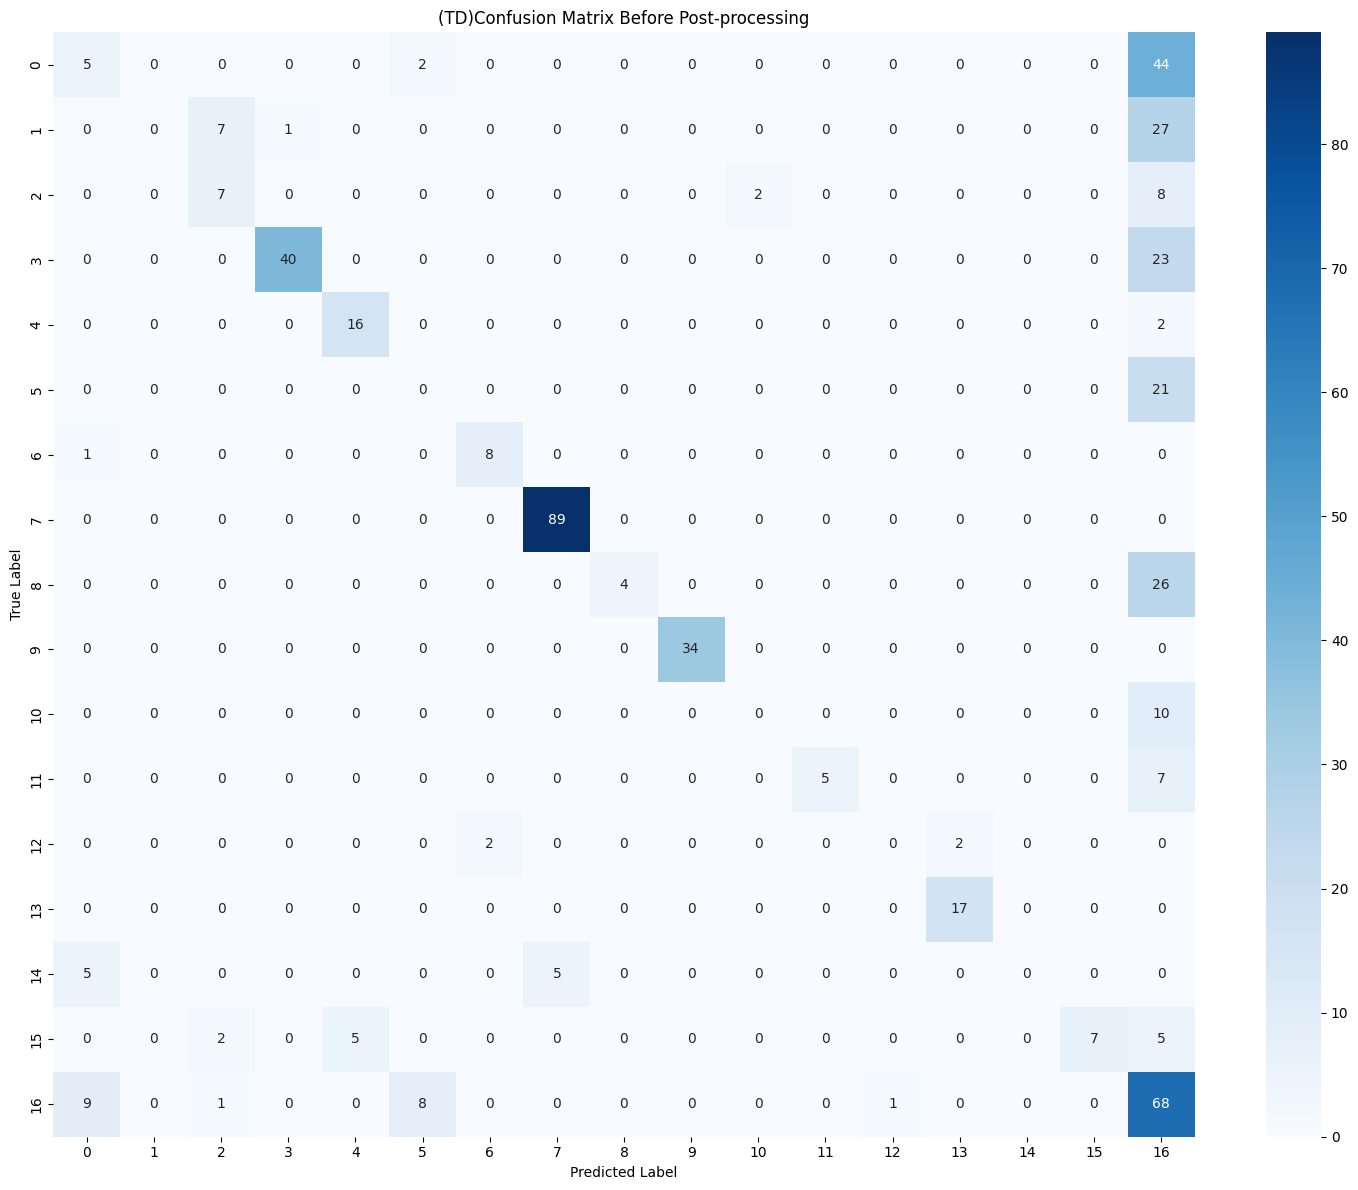

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 获取预测结果
y_pred = model_rf.predict(test_all_features)

# 打印分类报告
print("Classification Report:")
print(classification_report(test_all_labels, y_pred))

# 计算混淆矩阵
cm = confusion_matrix(test_all_labels, y_pred, labels=np.arange(17))  # 确保使用0-16的标签

# 创建更大的图表
plt.figure(figsize=(15, 12))  # 调整为更大的尺寸

# 绘制热力图
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.arange(17),  # 使用0-16的标签
            yticklabels=np.arange(17))

# 设置标题和标签
plt.title("(TD)Confusion Matrix Before Post-processing")  # 增加标题和图表的间距
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()